In [169]:
import torch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import plotly.express as px
from einops import *

from torch.distributions.multivariate_normal import MultivariateNormal
from torch.distributions.normal import Normal
from torch.distributions.exponential import Exponential
from torch.distributions.categorical import Categorical

In [227]:
d_mlp = 512

midvec_corr = 0.5

midvec_cov = torch.tensor([[1., midvec_corr], [midvec_corr, 1.]])
midvecs = MultivariateNormal(torch.zeros(2), midvec_cov).sample((d_mlp,))

In [228]:
prob_cooccur= 0.33
act_mean = 1
act_std = 0.3

prob_1_only = (1 - prob_cooccur) * 0.5
prob_2_only = 1 - prob_1_only

n_samples = int(1e4)
acts = Normal(act_mean, act_std**2).sample((n_samples,2)).float()

probs = torch.tensor([prob_1_only, prob_2_only, prob_cooccur])
occurence_types = Categorical(probs).sample((n_samples,)).float()

left_mask = (occurence_types==1)
right_mask = (occurence_types==0)
acts[left_mask,0] = 0
acts[right_mask,1] = 0

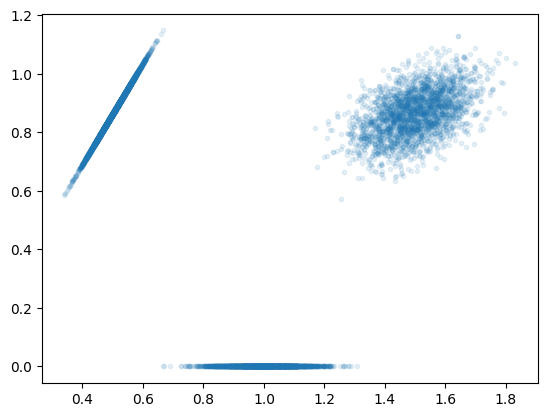

In [229]:
cos_sim = torch.nn.functional.cosine_similarity(midvecs[:,0], midvecs[:,1], dim=0).item()

midvecs_plot = acts @ torch.tensor([[1, 0], [cos_sim, np.sqrt(1-cos_sim**2)]]).float()

plt.plot(midvecs_plot[:,0], midvecs_plot[:,1],'.', alpha=0.1)

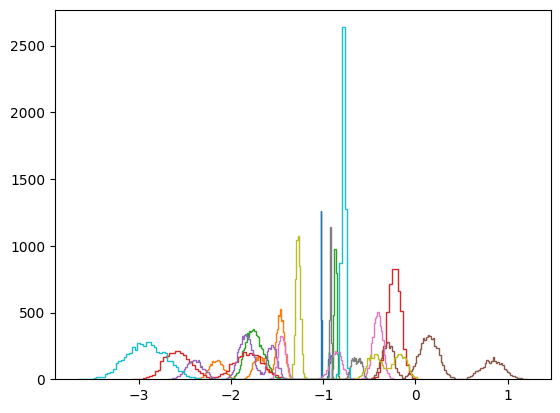

In [257]:
bias = -1
noise_std = 1

pre_relu = acts @ midvecs.T + bias
gate_probs = 0.5 + 0.5 * torch.special.erf((-pre_relu)/(np.sqrt(2) * noise_std))
gates = Bernoulli(gate_probs).sample((1,))[0]

Wout = torch.randn((d_mlp, d_mlp))/np.sqrt(d_mlp)
mlp_out = (pre_relu * gates) @ Wout

for k in range(10):
    plt.hist(pre_relu[:,k],100, histtype='step');

In [258]:
mask = occurence_types==0
decoder1 = ((acts[mask,0][:,None] @ midvecs.T[[0],:]) * gates[mask]) @ Wout
decoder1 = decoder1.mean(dim=0)

mask = occurence_types==1
decoder2 = ((acts[mask,1][:,None] @ midvecs.T[[1],:]) * gates[mask]) @ Wout
decoder2 = decoder2.mean(dim=0)

mask = occurence_types==2
decoder_AND = ((acts[mask] @ midvecs.T) * gates[mask]) @ Wout
decoder_AND = decoder_AND.mean(dim=0)

In [259]:
a = torch.nn.functional.cosine_similarity(decoder1, decoder2, dim=0).item()
b = torch.nn.functional.cosine_similarity(decoder1, decoder_AND, dim=0).item()
c = torch.nn.functional.cosine_similarity(decoder2, decoder_AND, dim=0).item()

d = (c - a*b)/np.sqrt(1-a**2)
plot_vecs = torch.tensor([[1, 0, 0],
        [a, np.sqrt(1-a**2), 0],
        [b, d, np.sqrt(1 - b**2 - d**2)]
        ]).float()

decoders = torch.stack([decoder1, decoder2, decoder_AND], dim=1)
decoders /= decoders.norm(dim=0, keepdim=True)
encoders = torch.linalg.pinv(decoders)

mask = occurence_types >= 0
df = pd.DataFrame({'x': (mlp_out[mask] @ encoders.T) @ plot_vecs[:,0],
        'y':(mlp_out[mask] @ encoders.T) @ plot_vecs[:,1],
        'z':(mlp_out[mask] @ encoders.T) @ plot_vecs[:,2]
})

fig = px.scatter_3d(df, x='x', y='y', z='z', opacity = 0.3)
fig.update_traces(marker_size = 1)


In [260]:
plot_vecs

tensor([[1.0000, 0.0000, 0.0000],
        [0.5111, 0.8595, 0.0000],
        [0.8532, 0.4774, 0.2101]])